In [0]:
import pandas as pd

filename = "pikabu_clean_dataset_2000.csv"
filename_hot = "hot_dataset_processed.csv"

In [0]:
data = pd.read_csv(filename)
data = data[['Text', 'Title', 'Tags', 'Rating']].dropna()

In [0]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.1)
iso_forest.fit(data[['Rating']])
iso_forest_prediction = iso_forest.predict(data[['Rating']])

In [0]:
indexes = [i for i in range(len(iso_forest_prediction)) if iso_forest_prediction[i] == -1]

In [0]:
data = data.drop(data.index[indexes])

In [0]:
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

with tf.Session() as session:
    session.run([tf.global_variables_initializer(), 
                 tf.tables_initializer()])
    #text_embeddings = session.run(embed(data['Text'][:1000]))
    text_embeddings = session.run(embed(data['Text'][:7000]))

In [0]:
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), 
                 tf.tables_initializer()])
    #title_embeddings = session.run(embed(data['Title'][:1000]))
    title_embeddings = session.run(embed(data['Title'][:7000]))

In [0]:
#tags = [text for text in data['Tags'][:1000]]
tags = [text for text in data['Tags'][:7000]]

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tags_encoding = vectorizer.fit_transform(tags)

In [0]:
from sklearn.model_selection import train_test_split #разбиение выборок
import numpy as np

vector_space = np.concatenate((tags_encoding.toarray(),title_embeddings,text_embeddings),axis=1)
#X_train, X_test, y_train, y_test = train_test_split(vector_space, data['Rating'][:1000], test_size=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(vector_space, data['Rating'][:7000], test_size=0.15, random_state=42)

In [22]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(X_train, y_train, verbose=False)

[17:45:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
import math
from sklearn.metrics import mean_squared_error
print('RMSE для тестовых данных равен: ' + str(math.sqrt(mean_squared_error([int(i) for i in model.predict(X_test)],y_test))))

RMSE для тестовых данных равен: 57.10066714010708


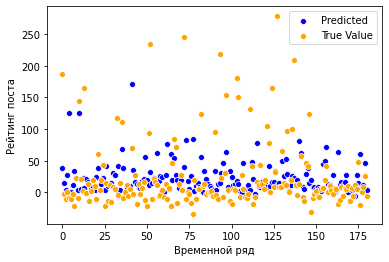

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

pred = [int(i) for i in model.predict(X_test)]
ax1 = sns.scatterplot(range(len(pred)),pred, color = 'blue', label="Predicted")
ax2 = sns.scatterplot(range(len(pred)),y_test, color = 'orange', label="True Value")
ax1.set(xlabel='Временной ряд', ylabel='Рейтинг поста')
plt.show()